In [15]:
import numpy as np
from scipy.integrate import odeint
import import_ipynb
import Vant_hoff_extrapolation as vanhof
from m6A_4_state_kinetic_sim import get_fit_result, plot_fitting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from uncertainties import ufloat
from uncertainties.umath import *
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'
sns.set_context('poster', font_scale=1.0)
%matplotlib inline

In [16]:
R = 0.00198588 #gas constant in kcal/mol

bol = 1.380649e-23 * 0.000239006# boltzman constant in kcal/K

plank = 6.62607015e-34 * 0.000239006 # planks constant kcal*s

def TAR_4_kinetic_equation(initial_c,t, *args):
    '''
    differential equation for 4-state square
    '''
    # concentrations for each molecule
    A, B, C, D = initial_c # A is the reactand, B/C are the intermediates on top right/bottom left, D is the product
    
    k1, k2, k3, k4, k5, k6, k7, k8 = args
    
    k_AB, k_BA, k_BD, k_DB, k_AC, k_CA, k_CD, k_DC = k1, k2, k3, k4, k5, k6, k7, k8
    
    dAdt = -A*(k_AC + k_AB) + B*k_BA + C*k_CA
    dBdt = -B*(k_BA + k_BD) + D*k_DB + A*k_AB
    dCdt = -C*(k_CA + k_CD) + D*k_DC + A*k_AC
    dDdt = -D*(k_DB + k_DC) + C*k_CD + B*k_BD
    
    return [dAdt, dBdt, dCdt, dDdt]

# define a exponetila equation for fitting
def ExpFit(X, a, R):
    return a*(1-np.exp(-R*X))

def k_to_dg(kon, koff, T = 65+273.15):
    global R
    dG = -R*T*log((kon/koff))
    return dG

def get_koff(dG, kon, T = 37+273.15):
    return kon/(exp(dG/(-R*T)))

# build the model
def model_building_prep(DNA_m6A_cs_k12, DNA_m6A_cs_k21, dG_DNA_m6A_total, DNA_A_kon, 
                       DNA_m6A_if_k12, DNA_m6A_if_k21, T, cs_fold = 1, if_fold = 20):
    '''
    get koff of hybridiztaion from CS and IF pathways
    DNA_m6A_cs_k12, DNA_m6A_cs_k21:  methyl rotation rate from RNA ssRNA methyl rotation
    dG_DNA_m6A_total: overall dG of m6A
    DNA_A_kon: kon of unmodified RNA/DNA
    DNA_m6A_if_k12, DNA_m6A_if_k21: methyl rotation rate from RNA dsRNA methyl rotation
    T: temperature in C
    '''
    # CS model building
    # free energy of the first step
    dG_DNA_cs1 = k_to_dg(DNA_m6A_cs_k12, DNA_m6A_cs_k21, T+273.15)

    # dG of the second step
    dG_DNA_cs2 = dG_DNA_m6A_total - dG_DNA_cs1

    # annealing assuming to be the same as unmodified DNA
    DNA_m6A_cs_k43 = get_koff(dG_DNA_cs2, DNA_A_kon/cs_fold, T+273.15)

    # get if pathway rate constants
    dG_DNA_if_2 = k_to_dg(DNA_m6A_if_k12, DNA_m6A_if_k21, T+273.15)
    # assuming x-fold slower than unmodified RNA
    DNA_m6A_if_45 = DNA_A_kon/if_fold
    DNA_m6A_if_54 = get_koff(dG_DNA_m6A_total+dG_DNA_if_2, DNA_m6A_if_45, T+273.15)
    
    return (DNA_m6A_cs_k43, DNA_m6A_if_54)

In [19]:
# get methyl rotation rates at 25C

# get parameters from van_hoff notebook
%store -r on_a_fl_ss
%store -r on_b_fl_ss
%store -r off_a_fl_ss
%store -r off_b_fl_ss
%store -r tharm_ss
%store -r on_a_fl_ds
%store -r on_b_fl_ds
%store -r off_a_fl_ds
%store -r off_b_fl_ds
%store -r tharm_ds

T = 25+273.15

k1_cs = vanhof.vanhoff_err(T, on_a_fl_ss, on_b_fl_ss, tharm_ss)
k2_cs = vanhof.vanhoff_err(T, off_a_fl_ss, off_b_fl_ss, tharm_ss)

k1_if = vanhof.vanhoff_err(T, on_a_fl_ds, on_b_fl_ds, tharm_ds)
k2_if = vanhof.vanhoff_err(T, off_a_fl_ds, off_b_fl_ds, tharm_ds)

# get wtTAR kon and koff from RD data
# kex_tar = ufloat(25807, 716)
# pB_TAR = ufloat(13, 2)/100

kex_tar = ufloat(32248, 4214)
pB_TAR = ufloat(21.9, 10)/100

k12_tar = kex_tar * pB_TAR
k21_tar = kex_tar * (1-pB_TAR)


# get RRE kon and koff from RD data
kex_RRE = ufloat(2311,109)
pB_RRE = ufloat(11.0, 0.4)/100
kex_RRE = ufloat(2364,53)
pB_RRE = ufloat(3.9,0.1)/100


k12_RRE = kex_RRE * pB_RRE
k21_RRE = kex_RRE * (1-pB_RRE)

#Monomer rate constant
kex_mono = ufloat(2124.,72)
pb_mono = ufloat(6.1,0.1)/100

k1_cs = kex_mono*pb_mono
k2_cs = kex_mono*(1-pb_mono)


f1, f2 = 0.5,20
# get koff from dG
k_cs_off, k_if_off = model_building_prep(k1_cs, k2_cs, k_to_dg(k12_tar, k21_tar, 25+273.15)+1 , k12_tar, k1_if, k2_if, 25, f1, f2)


kon is 1161.17+/-1.53
koff is 53.852396+/-0.071235
x is 89.53%
x is 0.01%
x is 5.82%
x is 4.64%


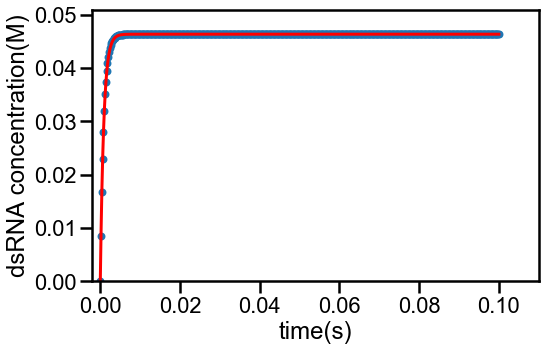

In [20]:
t_A = np.linspace(0, 0.1, 500)

k_tar = (k12_tar.n/f2, k_if_off.n, k2_if.n, k1_if.n, k1_cs.n, k2_cs.n, k12_tar.n/f1, k_cs_off.n)

pB_ss, kon, koff, params, data, conc_results, err = get_fit_result(ExpFit, TAR_4_kinetic_equation, (1, 0, 0, 0), t_A,
               k_tar,1,p0=[200, 10],bounds=(0, (np.inf, np.inf)))

plot_fitting(t_A, data, ExpFit, params, pB_ss, kon, koff)

for i in conc_results[-1,:]:
    print('x is {:.2%}'.format(i))